In [ ]:
import os
import tensorflow as tf
from keras import layers, models
from keras.applications import VGG16
import matplotlib.pyplot as plt

In [25]:
DATASET_PATH = "/Users/brittaneyjin/Desktop/damage predictor repo/damage-predictor/HurricaneHarvey"
IMG_SIZE = (128, 128)  # Resize images
BATCH_SIZE = 16
NUM_CLASSES = 5  # Adjust based on dataset categories
EPOCHS = 3

In [26]:
def load_datasets(dataset_path, img_size, batch_size):
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_path, "train_another"),
        image_size=img_size,
        batch_size=batch_size
    )
    val_dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_path, "validation_another"),
        image_size=img_size,
        batch_size=batch_size
    )
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_path, "test_another"),
        image_size=img_size,
        batch_size=batch_size
    )

    normalization_layer = layers.Rescaling(1.0 / 255)
    train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
    test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
    return train_dataset, val_dataset, test_dataset

# Load datasets
train_ds, val_ds, test_ds = load_datasets(DATASET_PATH, IMG_SIZE, BATCH_SIZE)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2)
])

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.


In [32]:
# VGG16 Architecture

def create_vgg16(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
def compile_and_train(model, train_dataset, val_dataset, epochs):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

    model.save('vgg16.keras')

    return history

def evaluate_model(model, test_dataset):
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_accuracy

def plot_training(history, title):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

Training VGG16...


Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 194s 309ms/step - accuracy: 0.8182 - loss: 1.1725 - val_accuracy: 0.9125 - val_loss: 0.2319
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 323ms/step - accuracy: 0.8828 - loss: 0.2666 - val_accuracy: 0.9180 - val_loss: 0.2082
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 205s 328ms/step - accuracy: 0.8974 - loss: 0.2464 - val_accuracy: 0.9060 - val_loss: 0.2068


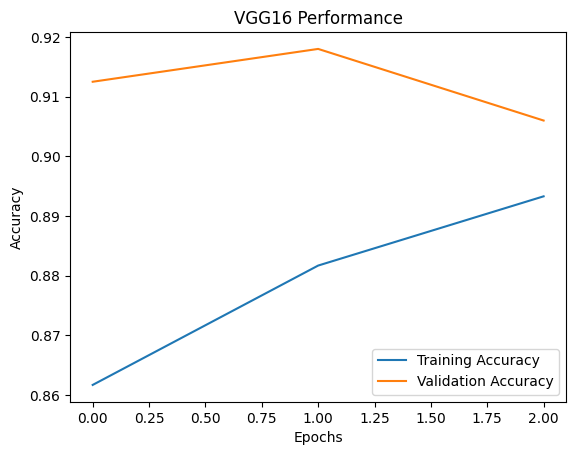

563/563 ━━━━━━━━━━━━━━━━━━━━ 132s 235ms/step - accuracy: 0.9433 - loss: 0.1463
Test Accuracy: 94.46%


0.9445555806159973

In [ ]:
input_shape = IMG_SIZE + (3,)  # Input shape for the models

# Train and evaluate VGG16
print("Training VGG16...")
vgg16 = create_vgg16(input_shape, NUM_CLASSES)
vgg16_history = compile_and_train(vgg16, train_ds, val_ds, EPOCHS)
plot_training(vgg16_history, "VGG16 Performance")
evaluate_model(vgg16, test_ds)

In [ ]:
from keras.preprocessing import image
import numpy as np

# test
img_path = "/Users/brittaneyjin/Desktop/damage predictor repo/damage-predictor/testingImages/AOI3-tile_5-2_pre_disaster.png"  # Update path as needed
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict with your trained model
prediction = vgg16.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

def load_datasets(dataset_path, img_size, batch_size):
    raw_train = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_path, "train_another"),
        image_size=img_size,
        batch_size=batch_size
    )
    class_names = raw_train.class_names  #capture this BEFORE mapping

    normalization_layer = layers.Rescaling(1.0 / 255)
    train_dataset = raw_train.map(lambda x, y: (normalization_layer(x), y))

    val_dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_path, "validation_another"),
        image_size=img_size,
        batch_size=batch_size
    ).map(lambda x, y: (normalization_layer(x), y))

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_path, "test_another"),
        image_size=img_size,
        batch_size=batch_size
    ).map(lambda x, y: (normalization_layer(x), y))

    return train_dataset, val_dataset, test_dataset, class_names

train_ds, val_ds, test_ds, class_names = load_datasets(DATASET_PATH, IMG_SIZE, BATCH_SIZE)
print("Predicted class:", class_names[predicted_class])


In [ ]:
# checking damage folder

from keras.preprocessing import image
import numpy as np
import os

total_dmg = 0

folder = "/Users/brittaneyjin/Desktop/damage predictor repo/damage-predictor/HurricaneHarvey/test/damage"
dmg_results = {}

for file_name in os.listdir(folder):
    img_path = os.path.join(folder, file_name)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = vgg16.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    label = class_names[predicted_class]

    dmg_results[file_name] = label
    total_dmg += 1

for key in dmg_results:
    print(f"{key}: {dmg_results[key]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

In [11]:
# compare values

dmgNoF = 0

for keys in dmg_results:
    if dmg_results[keys] == 'no_damage':
        dmgNoF += 1
        print(keys)

-95.64638599999999_29.832628000000003.jpeg
-95.078963_29.826764.jpeg
-96.866467_28.777668.jpeg
-96.872861_28.634386.jpeg
-95.656526_29.831674.jpeg
-96.888346_28.45712.jpeg
-95.080779_29.824353000000002.jpeg
-93.678446_30.205085999999998.jpeg
-96.886596_28.767073.jpeg
-95.57414200000001_29.759424.jpeg
-96.99602800000001_28.525226.jpeg
-96.899056_28.761097999999997.jpeg
-95.61875500000001_29.778781.jpeg
-95.617985_29.761082000000002.jpeg
-96.998337_28.532915000000003.jpeg
-96.898065_28.4596.jpeg
-95.67011600000001_29.818346999999996.jpeg
-93.682517_29.782388.jpeg
-96.917827_28.839014000000002.jpeg
-95.077515_29.826657.jpeg
-96.97191_28.787588.jpeg
-96.99995600000001_28.86675.jpeg
-96.87576899999999_28.76766.jpeg
-96.960669_28.783790999999997.jpeg
-96.995373_28.619082000000002.jpeg
-96.985364_28.806690999999997.jpeg
-95.62061899999999_29.766195.jpeg
-96.889199_28.644571000000003.jpeg
-96.979943_28.786444.jpeg
-95.075787_29.829223.jpeg
-93.669804_30.221032.jpeg
-96.892114_28.73909600000000

In [ ]:
# checking no damage folder

from keras.preprocessing import image
import numpy as np
import os

total_no = 0

folder = "/Users/brittaneyjin/Desktop/damage predictor repo/damage-predictor/HurricaneHarvey/test/no_damage"
no_dmgResults = {}

for file_name in os.listdir(folder):
    img_path = os.path.join(folder, file_name)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = vgg16.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    label = class_names[predicted_class]

    no_dmgResults[file_name] = label

    total_no += 1

for key in no_dmgResults:
    print(f"{key}: {no_dmgResults[key]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [13]:
# compare values

noDmgF = 0

for keys in no_dmgResults:
    if no_dmgResults[keys] == 'damage':
        noDmgF += 1
        print(keys)

-96.997799_28.809227000000003.jpeg
-96.985391_28.7823.jpeg
-96.934568_28.496004.jpeg
-96.981255_28.76615.jpeg
-96.972004_28.501972.jpeg
-95.269346_29.592471999999997.jpeg
-95.32691700000001_29.594119.jpeg
-96.99091899999999_28.773956.jpeg
-95.302842_29.459876.jpeg
-95.374611_30.040964000000002.jpeg
-96.990543_28.792906.jpeg
-96.97493_28.800534999999996.jpeg
-96.98737_28.763407.jpeg
-96.964979_28.624012.jpeg
-96.969241_28.61836.jpeg
-95.484255_30.021665999999996.jpeg
-95.303884_29.459982.jpeg
-95.639169_29.957859999999997.jpeg
-96.983873_28.803201.jpeg
-95.26799100000001_29.604390999999996.jpeg
-96.98546_28.785055.jpeg
-96.977349_28.771224.jpeg
-95.648954_29.830091999999997.jpeg
-95.165729_29.432206.jpeg
-96.933984_28.724248.jpeg
-95.232861_30.022837.jpeg
-95.655836_29.838328000000004.jpeg
-96.982672_28.773296999999996.jpeg
-95.153747_30.031442.jpeg
-95.666023_29.836406.jpeg
-95.162836_29.432209000000004.jpeg
-96.99602800000001_28.525226.jpeg
-96.96569699999999_28.662392999999998.jpeg
-

In [14]:
# comparing true/false values

# DAMAGE FOLDER
print(f'TOTAL DAMAGE FILES: {total_dmg}')
print(f'FALSE NO DAMAGE: {dmgNoF}')

# NO DAMAGE FOLDER
print(f'TOTAL NO DAMAGE FILES: {total_no}')
print(f'FALSE DAMAGE: {noDmgF}')

noFalse = dmgNoF/total_dmg
noFalse = 1-noFalse

dmgFalse = noDmgF/total_no
dmgFalse = 1-dmgFalse

print('\n')

print(f'DAMAGE FOLDER: {noFalse}% ACCURACY')
print(f'NO DAMAGE FOLDER: {dmgFalse}% ACCURACY')


TOTAL DAMAGE FILES: 1000
FALSE NO DAMAGE: 47
TOTAL NO DAMAGE FILES: 1000
FALSE DAMAGE: 137


DAMAGE FOLDER: 0.953% ACCURACY
NO DAMAGE FOLDER: 0.863% ACCURACY


# now testing the data it was NOT trained from #

In [ ]:
# checking testingImages [PRE DAMAGE] folder

from keras.preprocessing import image
import numpy as np
import os

pre = 0

folder = "/Users/brittaneyjin/Desktop/damage predictor repo/damage-predictor/testingImages/pre damage"
pre_dmg = {}

for file_name in os.listdir(folder):
    img_path = os.path.join(folder, file_name)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = vgg16.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    label = class_names[predicted_class]

    pre_dmg[file_name] = label

    pre += 1

for key in pre_dmg:
    print(f"{key}: {pre_dmg[key]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [ ]:
# checking testingImages [POST DAMAGE] folder

from keras.preprocessing import image
import numpy as np
import os

post = 0

folder = "/Users/brittaneyjin/Desktop/damage predictor repo/damage-predictor/testingImages/post damage"
post_dmg = {}

for file_name in os.listdir(folder):
    img_path = os.path.join(folder, file_name)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = vgg16.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    label = class_names[predicted_class]

    post_dmg[file_name] = label

    post += 1

for key in post_dmg:
    print(f"{key}: {post_dmg[key]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [17]:
# compare values

pre_false = 0

for keys in pre_dmg:
    if pre_dmg[keys] == 'damage':
        pre_false += 1
        print(keys)

AOI1-tile_2-4_pre_disaster.png
AOI1-tile_1-3_pre_disaster.png
AOI1-tile_2-3_pre_disaster.png


In [18]:
# compare values

post_false = 0

for keys in post_dmg:
    if post_dmg[keys] == 'damage':
        post_false += 1
        print(keys)

AOI1-tile_7-1_post_disaster.png
AOI1-tile_2-4_post_disaster.png
AOI1-tile_2-3_post_disaster.png
AOI1-tile_1-3_post_disaster.png
AOI1-tile_10-3_post_disaster.png


In [19]:
# comparing true/false values

# DAMAGE FOLDER
print(f'TOTAL DAMAGE FILES: {post}')
print(f'FALSE NO DAMAGE: {post_false}')

# NO DAMAGE FOLDER
print(f'TOTAL NO DAMAGE FILES: {pre}')
print(f'FALSE DAMAGE: {pre_false}')

preFalse = pre_false/pre
preFalse = 1-preFalse

postFalse = post_false/post
postFalse = 1-postFalse

print('\n')

print(f'DAMAGE FOLDER: {postFalse}% ACCURACY')
print(f'NO DAMAGE FOLDER: {preFalse}% ACCURACY')


TOTAL DAMAGE FILES: 87
FALSE NO DAMAGE: 5
TOTAL NO DAMAGE FILES: 87
FALSE DAMAGE: 3


DAMAGE FOLDER: 0.9425287356321839% ACCURACY
NO DAMAGE FOLDER: 0.9655172413793104% ACCURACY
